# Skin Cancer Detection

### 1. Importing Libraries

In [1]:
# for data manipulation
import pandas as pd
import numpy as np

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# DL Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D , MaxPooling2D ,Dropout , Flatten , Dense ,BatchNormalization ,Concatenate ,Input 
from keras.models import Sequential ,Model

# SK Learn library to split train and test data
from sklearn.model_selection import train_test_split

# other libraries
import cv2
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array, load_img

### 2. Loading Data

In [2]:
# loading the csv file

metadata = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
metadata.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
metadata.shape

(10015, 7)

In [4]:
metadata.count()

lesion_id       10015
image_id        10015
dx              10015
dx_type         10015
age              9958
sex             10015
localization    10015
dtype: int64

In [5]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [6]:
# checking for the null values

metadata.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [7]:
# replacing the missing values of age with mean

metadata['age'] = metadata['age'].fillna(round(metadata['age'].mean()))
metadata.isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

### 3. EDA

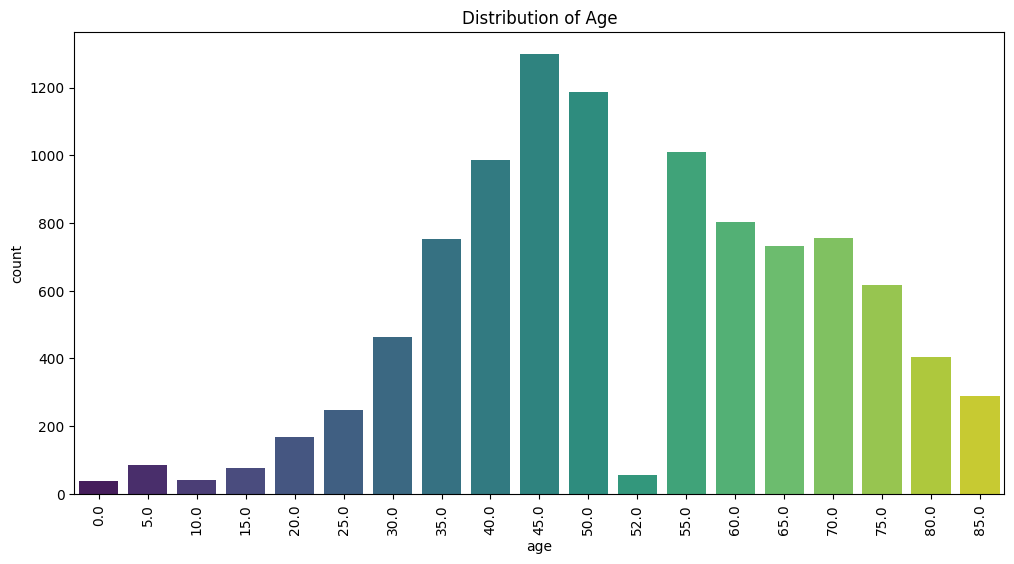

In [8]:
# distribution of ages

plt.figure(figsize=(12,6))
sns.countplot(data=metadata ,x='age',palette='viridis')
plt.title('Distribution of Age')
plt.xticks(rotation=90)

plt.show()

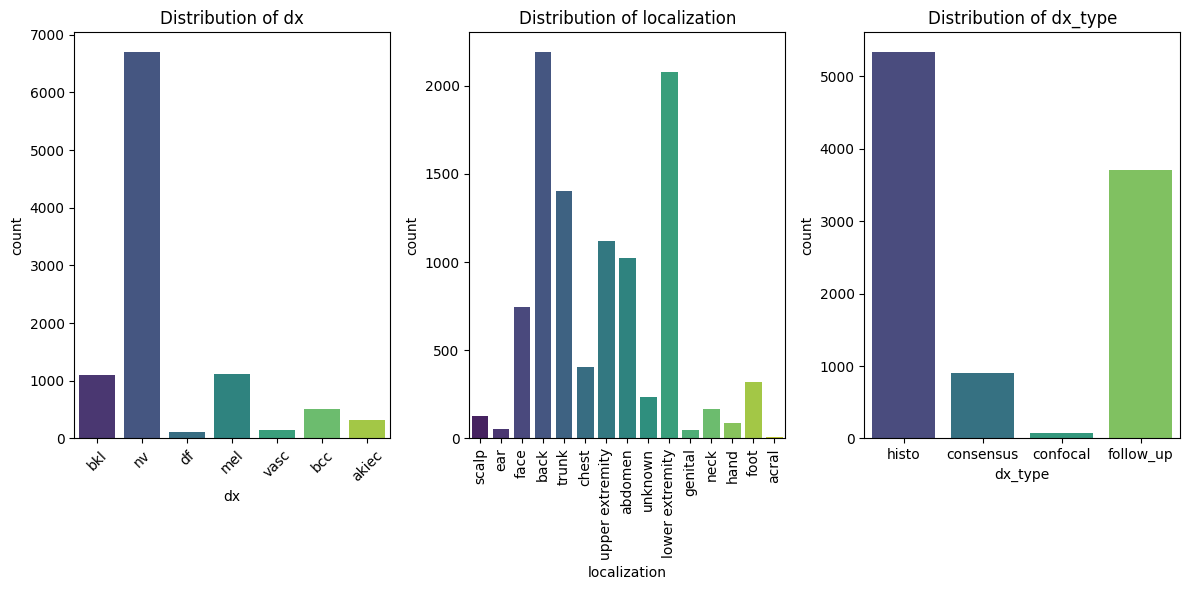

In [9]:
# distribution of other features
# dx, dx-type, localization

plt.figure(figsize=(12, 6))


plt.subplot(1,3,1)
sns.countplot(data=metadata , x='dx' ,palette='viridis')
plt.title('Distribution of dx')
plt.xticks(rotation=45)


plt.subplot(1,3,2)
sns.countplot(data=metadata,x='localization' ,palette='viridis')
plt.title('Distribution of localization')
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.countplot(data=metadata , x = 'dx_type' , palette='viridis')
plt.title('Distribution of dx_type')

plt.tight_layout()
plt.show()

In [10]:
# uniqe value counts of sex column

metadata['sex'].value_counts()

sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64

In [11]:
# replacing unknown values in the sex column with male
# to prevent having extra column during label encoding

metadata['sex'] = metadata['sex'].replace('unknown', 'male')

metadata['sex'].value_counts()

sex
male      5463
female    4552
Name: count, dtype: int64

In [12]:
# X_features include - age, dx_type, sex, localization
# y_feature - dx

metadata_features = metadata[['age', 'dx_type', 'sex', 'localization']].copy()

In [13]:
metadata_features.head()

,age,dx_type,sex,localization
0,80.0,histo,male,scalp
1,80.0,histo,male,scalp
2,80.0,histo,male,scalp
3,80.0,histo,male,scalp
4,75.0,histo,male,ear


In [14]:
# changing categorical data into numerical data using dummies
metadata_features = pd.get_dummies(metadata_features, columns=['dx_type', 'sex', 'localization'], drop_first=True, dtype=int)

In [15]:
metadata_features.head()

,age,dx_type_consensus,dx_type_follow_up,dx_type_histo,sex_male,localization_acral,localization_back,localization_chest,localization_ear,localization_face,localization_foot,localization_genital,localization_hand,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity
0,80.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,80.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,80.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,80.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,75.0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [16]:
# normalizing the age value
metadata_features['age'] = metadata_features['age'] / metadata_features['age'].max()
metadata_features

,age,dx_type_consensus,dx_type_follow_up,dx_type_histo,sex_male,localization_acral,localization_back,localization_chest,localization_ear,localization_face,localization_foot,localization_genital,localization_hand,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity
0,0.941176,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0.941176,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0.941176,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0.941176,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0.882353,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,0.470588,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10011,0.470588,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10012,0.470588,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10013,0.941176,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [17]:
label_mapping = {
    "bkl": 0,
    "nv": 1,
    "df": 2,
    "mel": 3,
    "vasc": 4,
    "bcc": 5,
    "akiec": 6
}

In [18]:
# function to load_image data
def load_image(image_id  , image_folder):
    image_path = os.path.join(image_folder , f'{image_id}.jpg')
    return Image.open(image_path)

### 4. Loading Images

In [19]:
image_folder1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
image_folder2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'

image_data = []
labels = []
for idx,row in metadata.iterrows():
    i_id = row['image_id']
    dx   = row['dx']
    
    try:
        image = load_image(i_id , image_folder1)
        
    except FileNotFoundError:
        image = load_image(i_id , image_folder2)

    image = image.resize((128,128))
    image = img_to_array(image) /255.0
    
    image_data.append(image)
    labels.append(label_mapping[dx])

In [20]:
classes = ['Benign Keratosis-like Lesions (bkl)',
           'Melanocytic Nevi (nv)',
           'Dermatofibroma (df)',
           'Melanoma (mel)',
           'Vascular Lesions (vasc)',
           'Basal Cell Carcinoma (bcc)',
           'Actinic Keratoses and Intraepithelial Carcinoma (akiec)']

### 5. Showing Images

In [21]:
def show_samples(i_dex):
    plt.imshow(image_data[i_dex])
    plt.xlabel(classes[labels[i_dex]])
    plt.show()

#### i. Sample image 1

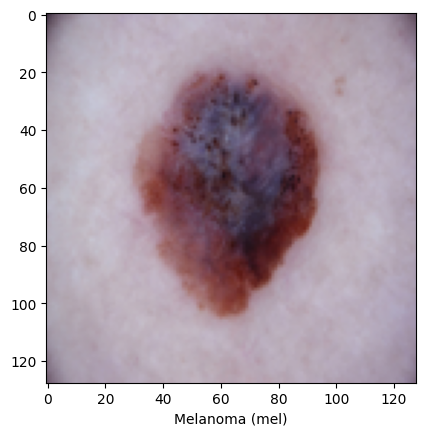

In [22]:
show_samples(1776)

#### ii. Sample image 2

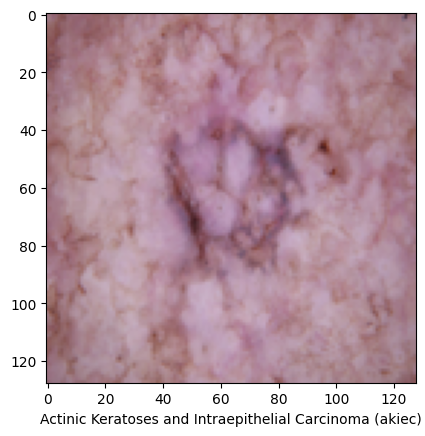

In [23]:
show_samples(9696)

#### iii. Sample image 3

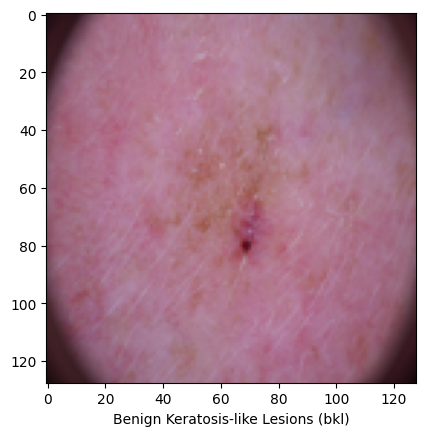

In [24]:
show_samples(786)

#### iv. Sample image 4

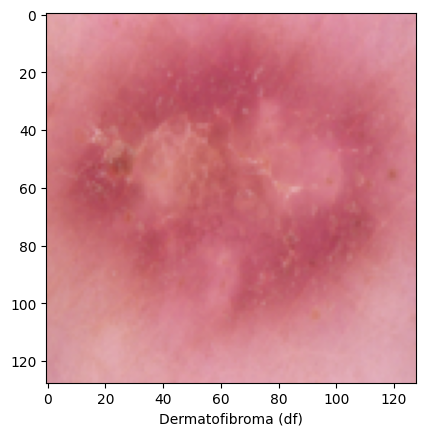

In [25]:
show_samples(1200)

#### v. Sample image 5

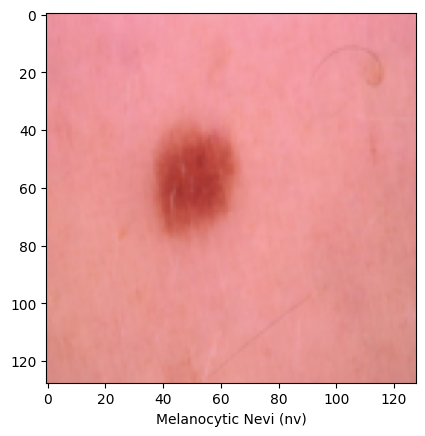

In [26]:
show_samples(6006)

In [27]:
X_image = np.array(image_data)

In [28]:
X_image.shape

(10015, 128, 128, 3)

In [29]:
y = np.array(labels)

In [30]:
y.shape

(10015,)

In [31]:
y_encoded = pd.get_dummies(y, dtype=int).values

In [32]:
y_encoded.shape

(10015, 7)

In [33]:
classes[np.argmax(y_encoded[1776])]

'Melanoma (mel)'

### 6. Model Implementation

In [34]:
# creating a CNN + ANN model

model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

# o/p layer
model.add(Dense(7, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,313,351 (12.64 MB)

 Trainable params: 3,313,351 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

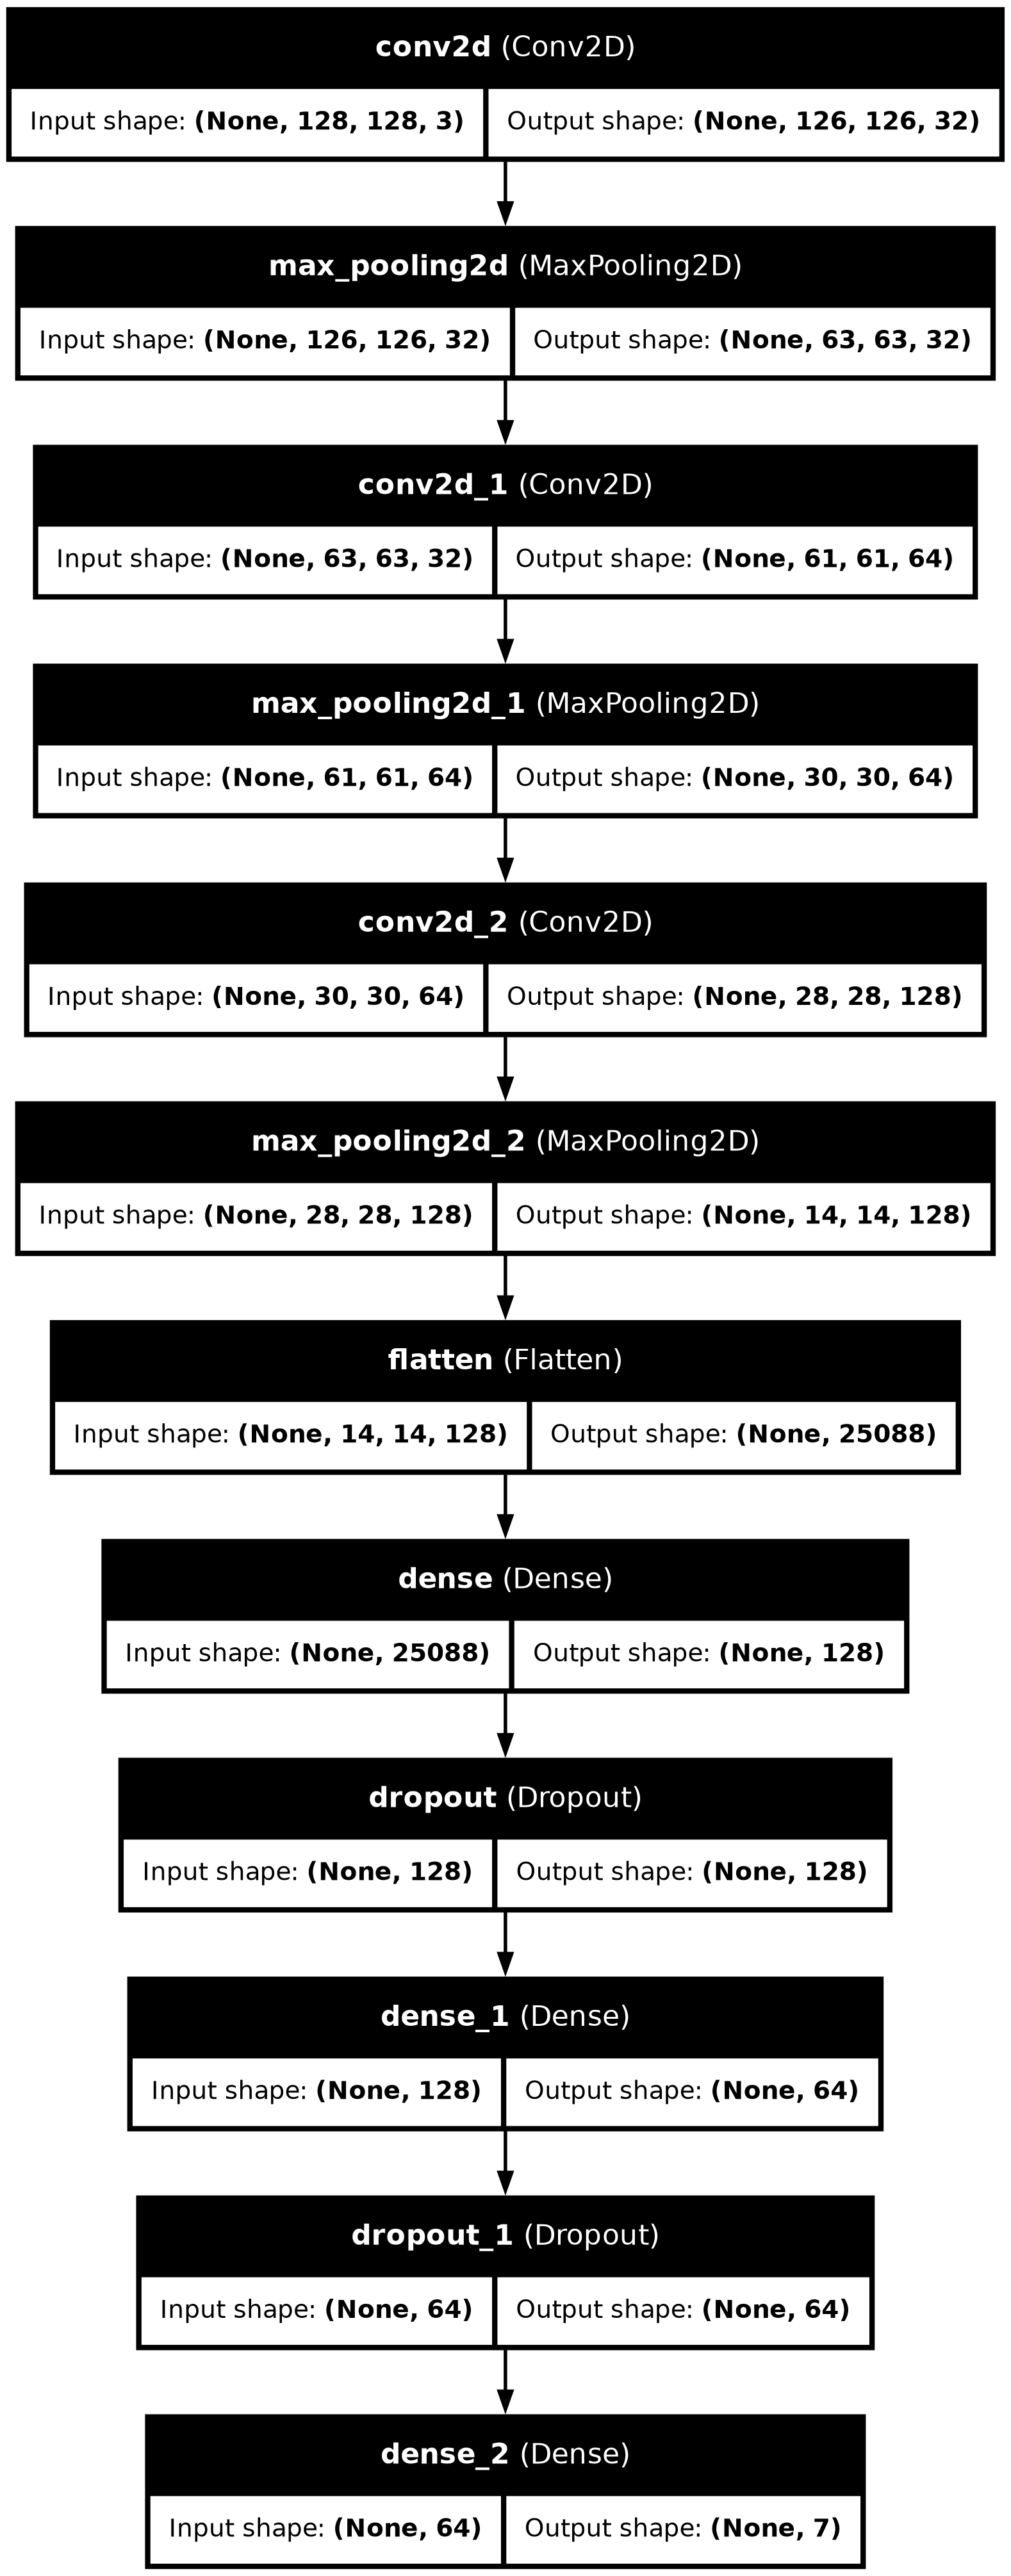

In [36]:
from keras.utils import plot_model
# plot_model(model)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### 7. Model Compilation

In [37]:
# model compilation

# model.compile(
#     optimizer='adam',
#     loss = 'categorical_crossentropy',
#     metrics=(['accuracy']))

from tensorflow.keras import metrics

# Model compilation with additional metrics
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall')
    ]
)

In [38]:
X_train_image, X_test_image, y_encoded_train ,y_encoded_test = train_test_split(X_image, y_encoded ,test_size=.2 ,random_state=42)

In [39]:
print(X_train_image.shape)
print(y_encoded_train.shape)

print(X_test_image.shape)
print(y_encoded_test.shape)

(8012, 128, 128, 3)
(8012, 7)
(2003, 128, 128, 3)
(2003, 7)


### 8. Model Fitting

In [40]:
history = model.fit(X_train_image, y_encoded_train,
                    validation_data=(X_test_image, y_encoded_test),
                    batch_size=32,
                    validation_split=.2,
                    epochs=25)

Epoch 1/25


I0000 00:00:1731948774.649868      72 service.cc:145] XLA service 0x7cf59800e110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731948774.649938      72 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731948774.649956      72 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  7/251 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.3305 - loss: 1.7424 - precision: 0.4055 - recall: 0.1443

I0000 00:00:1731948780.893712      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


251/251 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.6358 - loss: 1.1355 - precision: 0.7452 - recall: 0.4682 - val_accuracy: 0.6680 - val_loss: 0.9159 - val_precision: 0.8191 - val_recall: 0.5696
Epoch 2/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6842 - loss: 0.9028 - precision: 0.8206 - recall: 0.5637 - val_accuracy: 0.6865 - val_loss: 0.8914 - val_precision: 0.8093 - val_recall: 0.5911
Epoch 3/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6847 - loss: 0.8785 - precision: 0.8204 - recall: 0.5779 - val_accuracy: 0.6775 - val_loss: 0.8819 - val_precision: 0.7787 - val_recall: 0.6236
Epoch 4/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6964 - loss: 0.8374 - precision: 0.8213 - recall: 0.5856 - val_accuracy: 0.6865 - val_loss: 0.8168 - val_precision: 0.8049 - val_recall: 0.6056
Epoch 5/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.7019 - loss: 0.8063 - precision: 0.8320 - recall: 0.5938 - val_accuracy: 0.7079 - val_loss: 0.7810 

### 9. Plotting the graphs - Accuracy, Loss, Precision, Recall

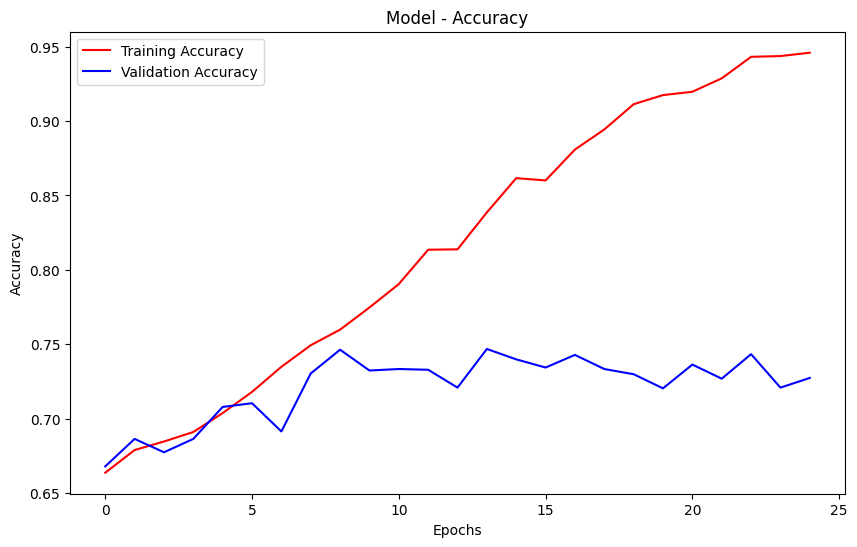

In [41]:
# plotting accuracy graph

# plt.plot(history.history['accuracy'], color='red', label='train')
# plt.plot(history.history['val_accuracy'], color='blue', label='validation')
# plt.legend()
# plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model - Accuracy')
plt.show()

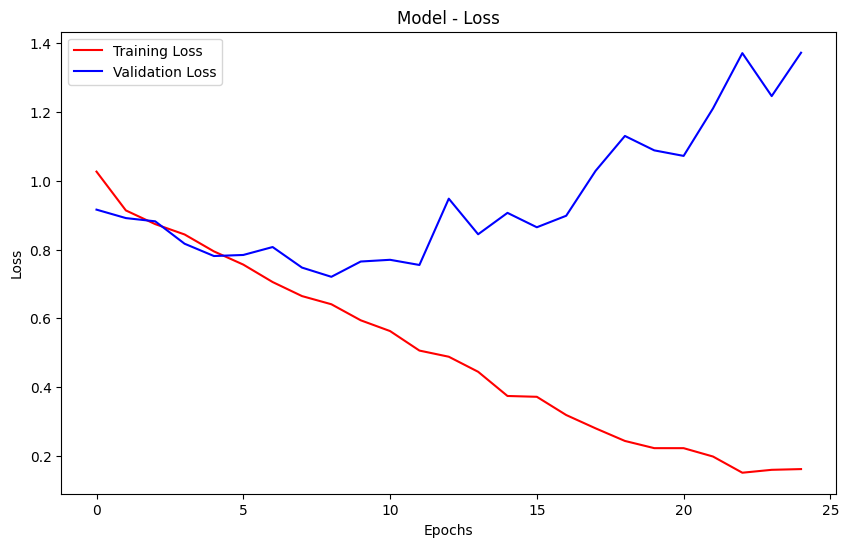

In [42]:
# # plotting loss graph

# plt.plot(history.history['loss'], color='red', label='train')
# plt.plot(history.history['val_loss'], color='blue', label='validation')
# plt.legend()
# plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], color='red', label='Training Loss')
plt.plot(history.history['val_loss'], color='blue', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model - Loss')
plt.show()

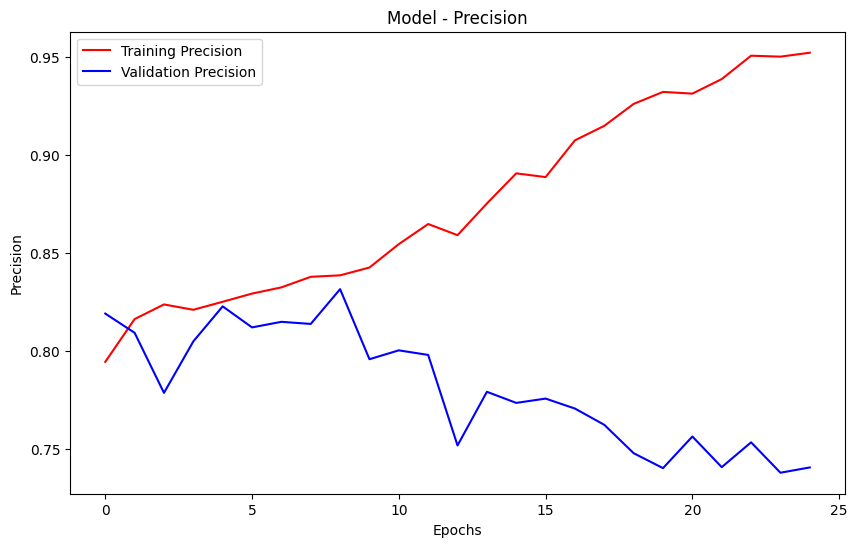

In [43]:
# Plot precision

plt.figure(figsize=(10, 6))
plt.plot(history.history['precision'], color='red', label='Training Precision')
plt.plot(history.history['val_precision'], color='blue', label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.title('Model - Precision')
plt.show()

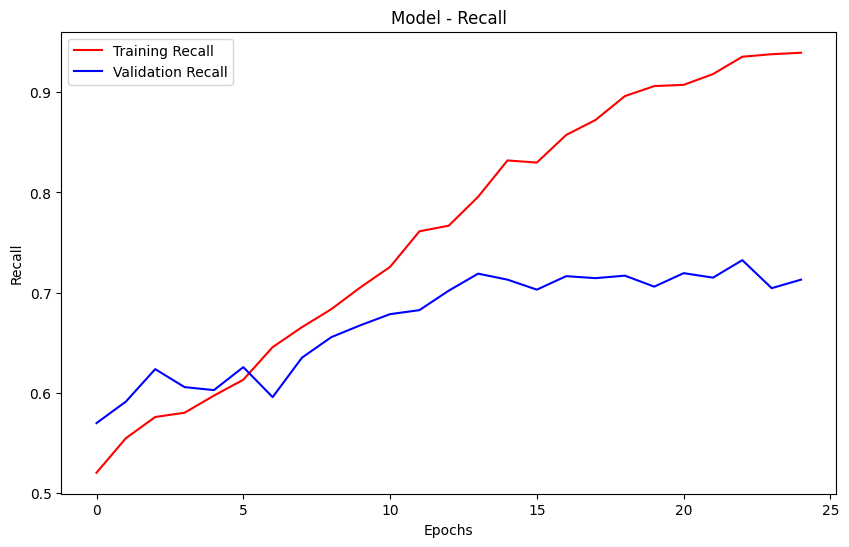

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['recall'], color='red', label='Training Recall')
plt.plot(history.history['val_recall'], color='blue', label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.title('Model - Recall')
plt.show()

### 10. Testing Data

#### i. Prediction 1

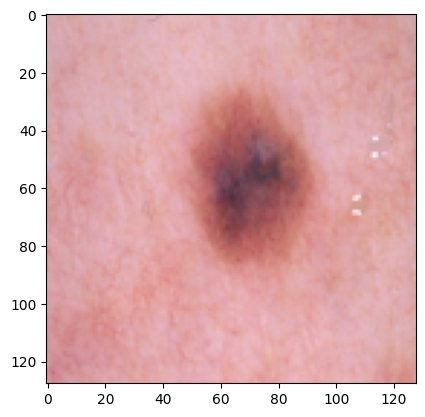

In [45]:
# Testing

plt.imshow(X_test_image[1])

In [46]:
y_encoded_test[1]

array([0, 1, 0, 0, 0, 0, 0])

In [47]:
np.argmax(y_encoded_test[1])

1

In [48]:
# classes[labels[i_dex]]
classes[np.argmax(y_encoded_test[1])]

'Melanocytic Nevi (nv)'

In [49]:
pred1 = model.predict(X_test_image[1].reshape(1,128,128,3))
np.argmax(pred1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


1

In [50]:
classes[np.argmax(np.argmax(pred1))]

'Benign Keratosis-like Lesions (bkl)'

#### ii. Prediction 2

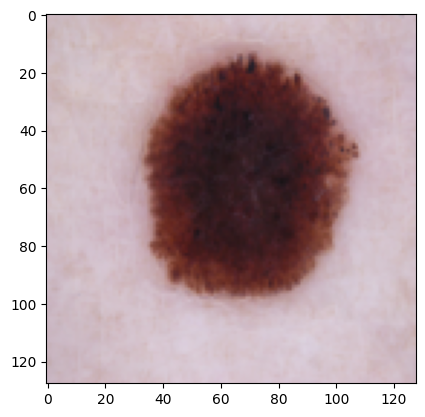

In [51]:
plt.imshow(X_test_image[357])

In [52]:
classes[np.argmax(y_encoded_test[357])]

'Melanoma (mel)'

In [53]:
pred2 = model.predict(X_test_image[357].reshape(1,128,128,3))
classes[np.argmax(np.argmax(pred2))]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


'Benign Keratosis-like Lesions (bkl)'

#### iii. Prediction 3

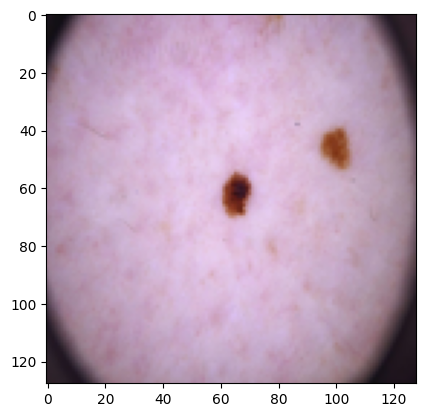

In [54]:
plt.imshow(X_test_image[900])

In [55]:
classes[np.argmax(y_encoded_test[900])]

'Melanoma (mel)'

In [56]:
pred3 = model.predict(X_test_image[900].reshape(1,128,128,3))
classes[np.argmax(np.argmax(pred3))]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


'Benign Keratosis-like Lesions (bkl)'

#### iv. Prediction 4

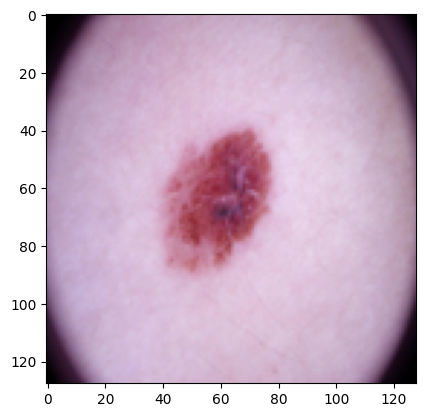

In [57]:
plt.imshow(X_test_image[1526])

In [58]:
classes[np.argmax(y_encoded_test[1526])]

'Melanocytic Nevi (nv)'

In [59]:
pred4 = model.predict(X_test_image[1526].reshape(1,128,128,3))
classes[np.argmax(np.argmax(pred4))]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


'Benign Keratosis-like Lesions (bkl)'

#### v. Prediction 5

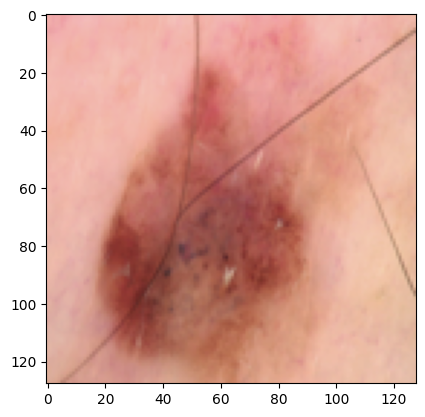

In [60]:
plt.imshow(X_test_image[2000])

In [61]:
classes[np.argmax(y_encoded_test[2000])]

'Melanoma (mel)'

In [62]:
pred5 = model.predict(X_test_image[2000].reshape(1,128,128,3))
classes[np.argmax(np.argmax(pred5))]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


'Benign Keratosis-like Lesions (bkl)'

### 11. Plotting the Predicted Confusion Matrix

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


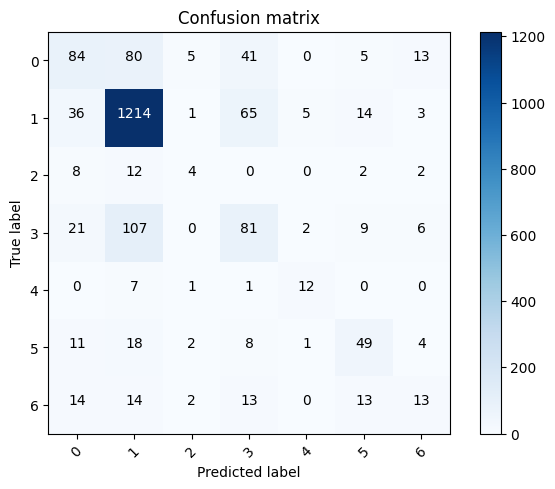

In [64]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else int(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test_image)
# Convert predictions classes to one-hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one-hot vectors
Y_true = np.argmax(y_encoded_test, axis=1)
# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(7))
plt.show()

## Experimenting

### Using Segemented images

In [65]:
# # Deleting Folder
# import shutil
# shutil.rmtree("/kaggle/working/")

In [66]:
import cv2
import numpy as np
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Directories for images
image_folder1 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1'
image_folder2 = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'

# Directory to save segmented images (optional)
segmented_image_dir = '/kaggle/working/segmented_images'
os.makedirs(segmented_image_dir, exist_ok=True)

# Function to segment an image
def segment_image(image_path):
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        return None  # Return None if the image could not be loaded

    # Convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply thresholding
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)
    
    # Draw contours
    cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)
    
    # Apply mask to isolate lesion
    segmented = cv2.bitwise_and(image, image, mask=mask)
    
    return segmented

# Segment all images and save the results
segmented_images = []
for idx, row in metadata.iterrows():
    image_id = row['image_id']
    dx = row['dx']
    
    # Construct the image path for each folder
    image_path1 = f"{image_folder1}/{image_id}.jpg"
    image_path2 = f"{image_folder2}/{image_id}.jpg"
    
    # Try to load and segment the image
    image = None
    if os.path.exists(image_path1):
        image = segment_image(image_path1)
    elif os.path.exists(image_path2):
        image = segment_image(image_path2)
    
    # If the image couldn't be loaded, skip it
    if image is None:
        print(f"Image not found or could not be read: {image_id}")
        continue

    # Resize the segmented image to the model's input size
    image = cv2.resize(image, (128, 128))
    image = img_to_array(image) / 255.0  # Normalize image to [0, 1]
    segmented_images.append(image)

    # Save the segmented image (optional)
    cv2.imwrite(os.path.join(segmented_image_dir, f"{image_id}_segmented.jpg"), (image * 255).astype(np.uint8))

# Convert segmented images to a NumPy array
segmented_images = np.array(segmented_images)

print(f"Total segmented images processed: {len(segmented_images)}")


Total segmented images processed: 10015


In [67]:
X_train_image, X_test_image, y_encoded_train ,y_encoded_test = train_test_split(segmented_images, y_encoded ,test_size=.2 ,random_state=42)

In [68]:
# # Use segmented images for training and testing
# X_train_image = segmented_images[:train_size]
# X_test_image = segmented_images[train_size:]

# Continue with your existing training code
history1 = model.fit(
    X_train_image, y_encoded_train, 
    epochs=25, 
    validation_data=(X_test_image, y_encoded_test)
)


Epoch 1/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7635 - loss: 1.5504 - precision: 0.8226 - recall: 0.7106 - val_accuracy: 0.7174 - val_loss: 0.9116 - val_precision: 0.7678 - val_recall: 0.6820
Epoch 2/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8873 - loss: 0.3266 - precision: 0.9247 - recall: 0.8537 - val_accuracy: 0.7269 - val_loss: 0.9863 - val_precision: 0.7681 - val_recall: 0.6980
Epoch 3/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9196 - loss: 0.2346 - precision: 0.9432 - recall: 0.8959 - val_accuracy: 0.7229 - val_loss: 1.1495 - val_precision: 0.7457 - val_recall: 0.7069
Epoch 4/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9174 - loss: 0.2355 - precision: 0.9334 - recall: 0.9020 - val_accuracy: 0.7359 - val_loss: 1.1208 - val_precision: 0.7507 - val_recall: 0.7184
Epoch 5/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9368 - loss: 0.1716 - precision: 0.9504 - recall: 0.9247 - val_accuracy: 0.7264 - val_los

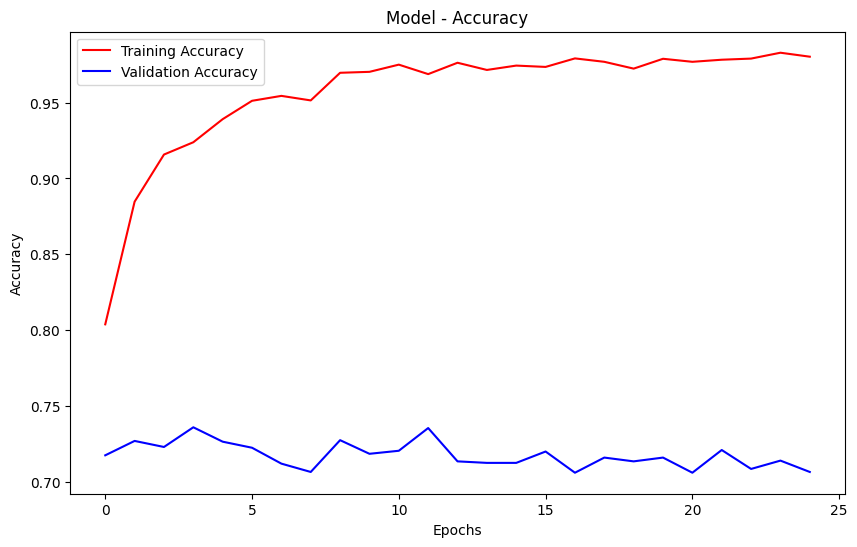

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(history1.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model - Accuracy')
plt.show()

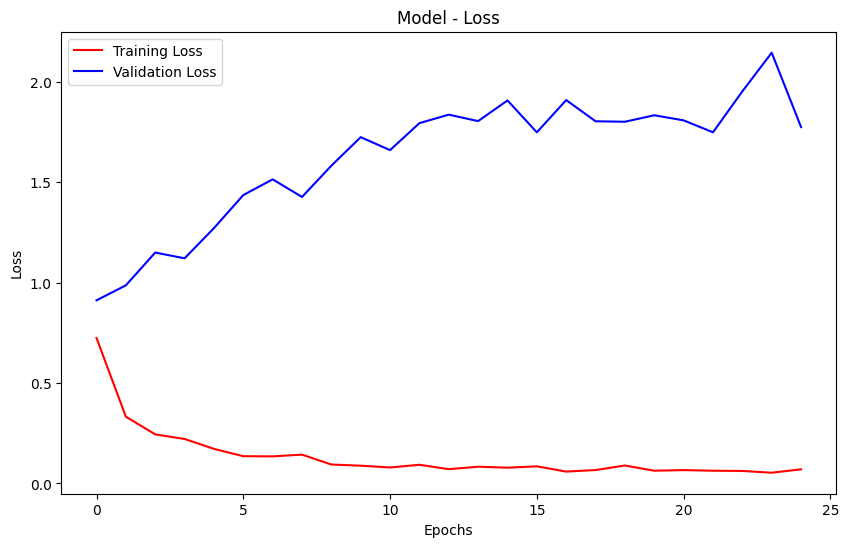

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(history1.history['loss'], color='red', label='Training Loss')
plt.plot(history1.history['val_loss'], color='blue', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model - Loss')
plt.show()